# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [13]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import plotly.express as px
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [14]:
# Configure API key 

quandl.ApiConfig.api_key = 'sBnMhNi9zN_e_ZtUz8Gz'

In [15]:
# Importing the Federal Reserve Economic Data "Producer Price Index by Commodity: Transportation Equipment: Ships and BoatsSeries'

data = quandl.get('FRED/WPS143')

In [16]:
data.head()

,Value
Date,
2008-01-01,215.2
2008-02-01,216.2
2008-03-01,216.7
2008-04-01,216.6
2008-05-01,217.1


In [17]:
data.shape

(133, 1)

In [18]:
data.columns

Index(['Value'], dtype='object')

In [19]:
type(data)

pandas.core.frame.DataFrame

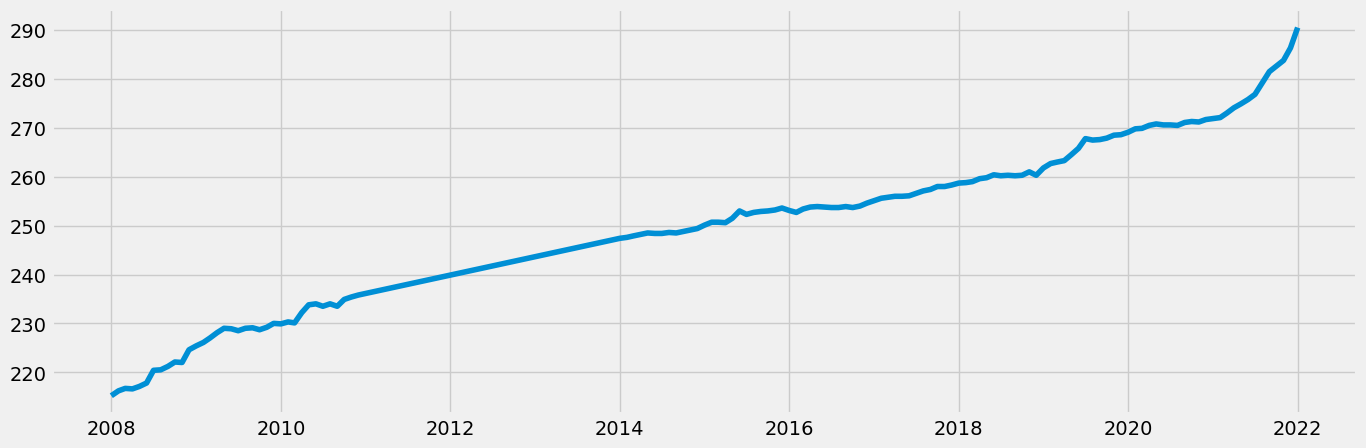

In [20]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [21]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [22]:
data_2.head()

,Date,Value
0,2008-01-01,215.2
1,2008-02-01,216.2
2,2008-03-01,216.7
3,2008-04-01,216.6
4,2008-05-01,217.1


In [23]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2023-06-01')]

In [24]:
data_sub.shape

(133, 2)

In [25]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2008-01-01,215.2
2008-02-01,216.2
2008-03-01,216.7
2008-04-01,216.6
2008-05-01,217.1


In [26]:
data_sub.columns

Index(['Value'], dtype='object')

In [27]:
data_sub.shape

(133, 1)

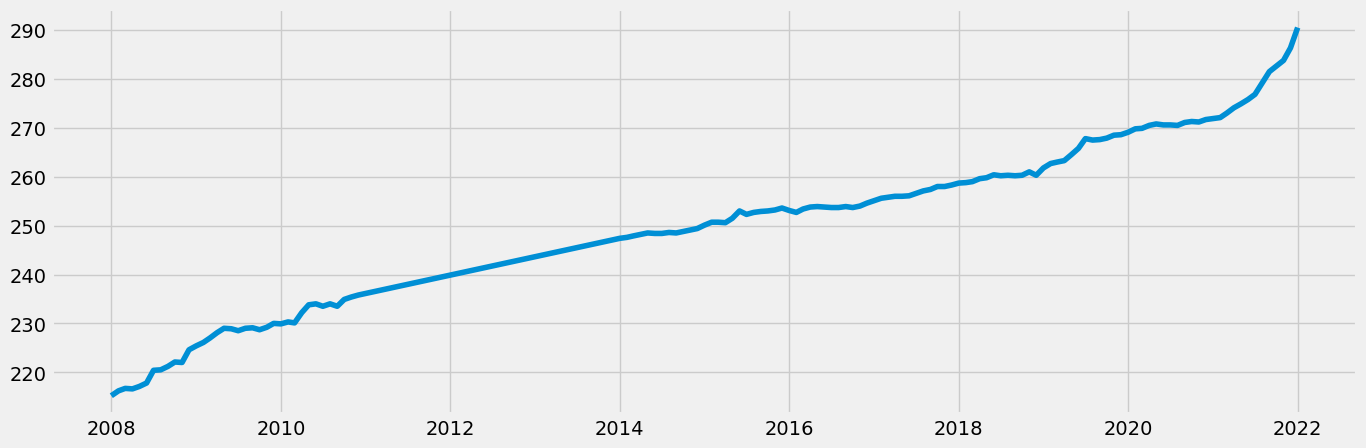

In [28]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [29]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() # No missing values

Value    0
dtype: int64

In [30]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

19

In [31]:
dups

datetime
2008-01-01    False
2008-02-01    False
2008-03-01    False
2008-04-01    False
2008-05-01    False
              ...  
2021-09-01    False
2021-10-01    False
2021-11-01    False
2021-12-01    False
2022-01-01    False
Length: 133, dtype: bool

In [32]:
# The dups found were "." in the value columns and only 19, so i will drop them

data_sub = data_sub.drop_duplicates()

In [33]:
data_sub.shape

(114, 1)

In [34]:
data_sub.columns


Index(['Value'], dtype='object')

### 3. Time-series analysis: decomposition

In [35]:
# Decompose the time series using an additive model

decomposition= sm.tsa.seasonal_decompose(data_sub, model='additive', period=1)

In [36]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

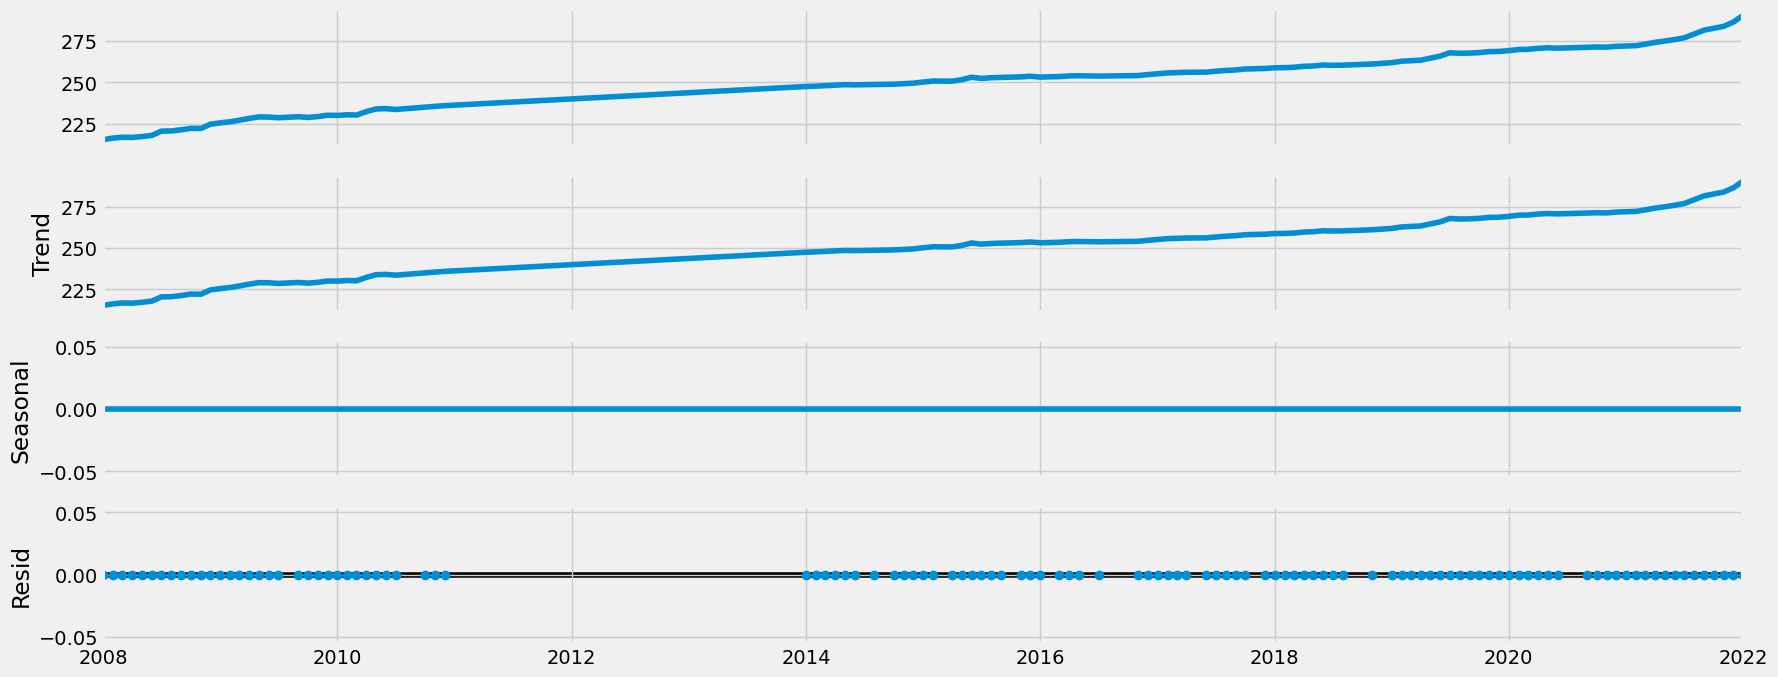

In [37]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Analysing this chart, we can see that this series is very probably non-stationary, since it shows a very proeminent upward trend,with no seasonality (this dataset had a seasonality adjustment performed), and pratically no noise , or residual value found. Since the original plot and the trend as very much the same, we can conclude that PPI has been growing from 2008 to 2022.

### 4. Testing for stationarity

In [38]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.050984
p-value                          0.962551
Number of Lags Used              0.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


#### null hypothesis: There is a unit root in the data hence the series is non-stationay

#### Test statistic larger than critical value = can’t reject null hypothesis
#### Test statistic smaller than critical value = can reject null hypothesis

#### Analysing the test and as visually suspected earlier the series is indeed non-stationary since we have a p-value >>0.05 and Test Statistic value  is way bigger than the critical value.

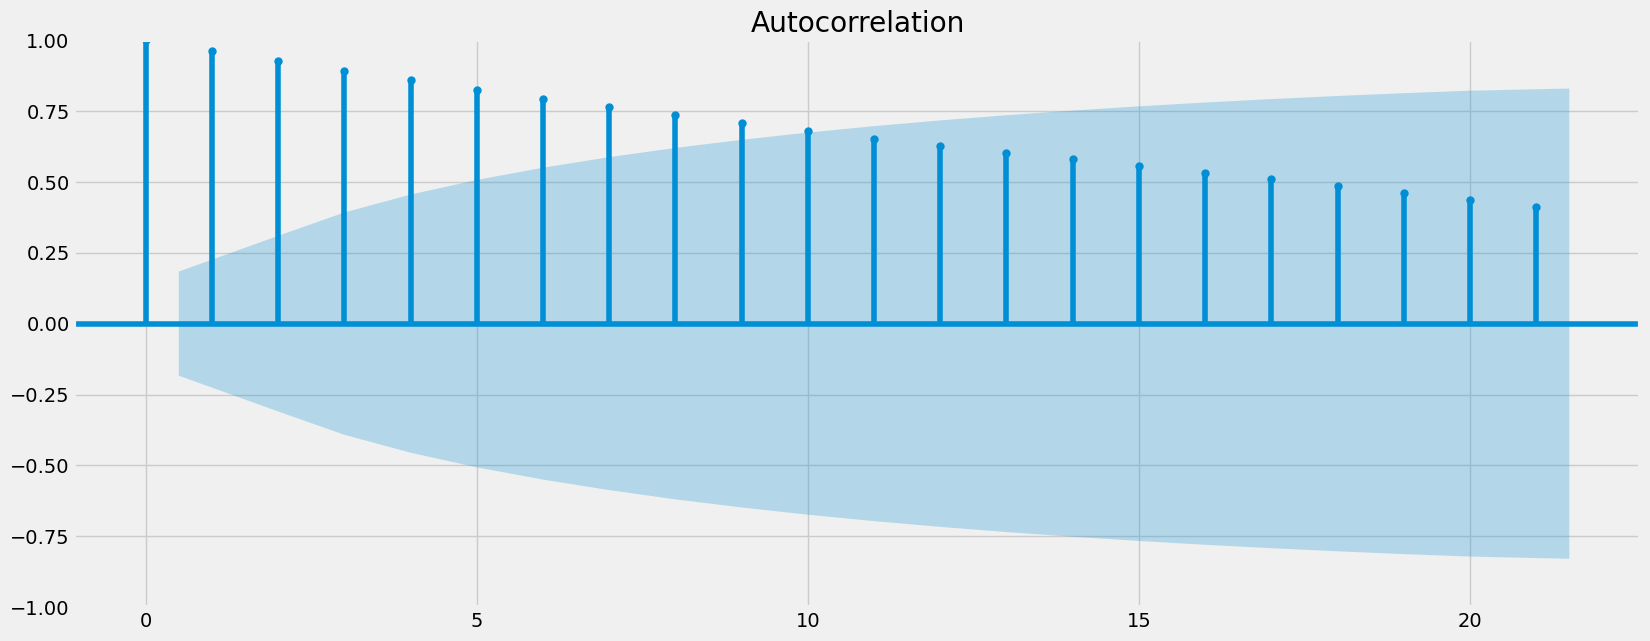

In [39]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

#### From the graph above we can see that there any many lags that land above the confidence interval, meaning that they are significantley correlated with each other, once again proving that the data series in non-stationary.

### 5. Stationarizing the Federal Reserve Economic Data

In [40]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [41]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [42]:
data_diff.head()

,Value
datetime,
2008-02-01,1.0
2008-03-01,0.5
2008-04-01,-0.1
2008-05-01,0.5
2008-06-01,0.7


In [43]:
data_diff.columns

Index(['Value'], dtype='object')

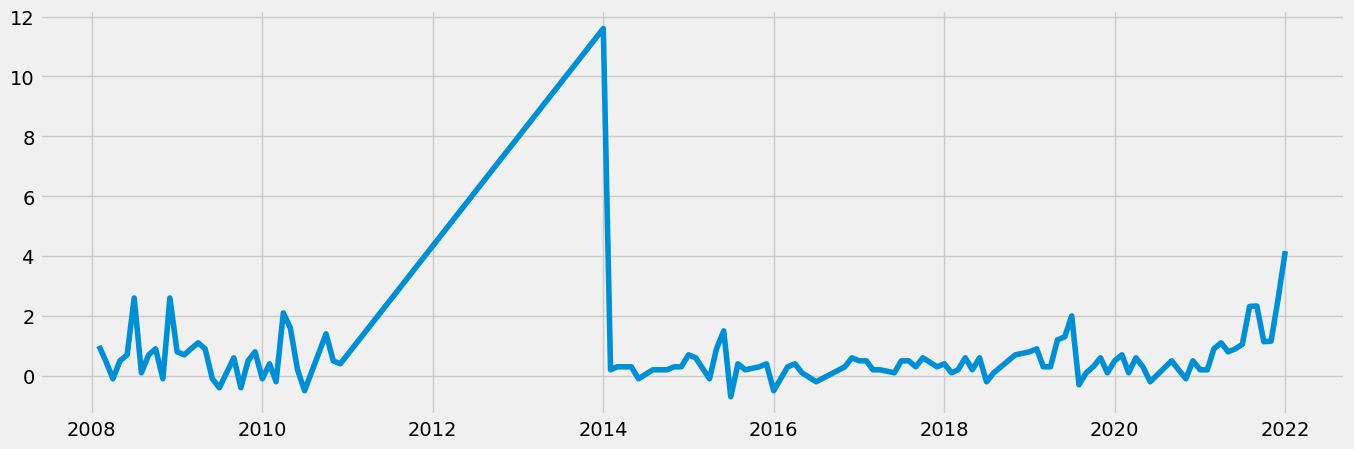

In [44]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [45]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.549571e+00
p-value                        2.593672e-16
Number of Lags Used            0.000000e+00
Number of Observations Used    1.120000e+02
Critical Value (1%)           -3.490131e+00
Critical Value (5%)           -2.887712e+00
Critical Value (10%)          -2.580730e+00
dtype: float64


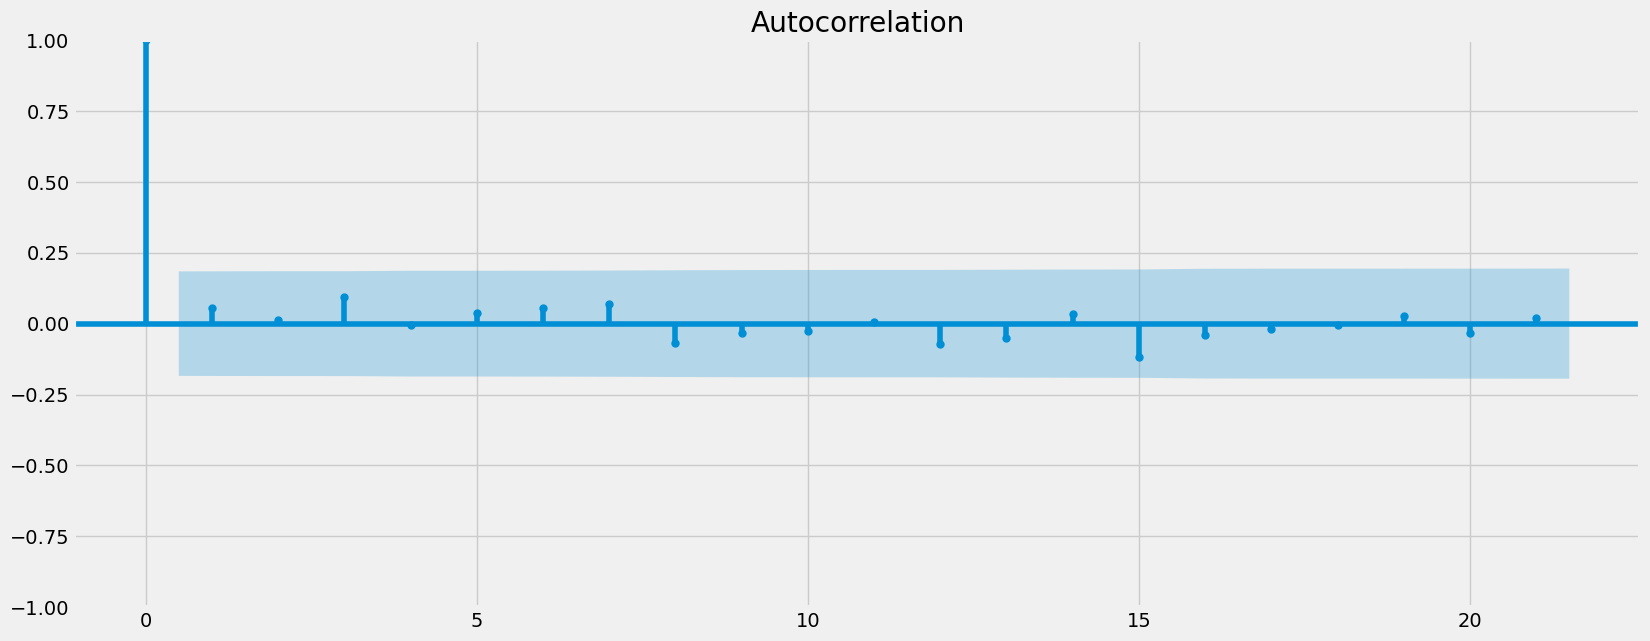

In [46]:
plot_acf(data_diff)
plt.show()